In [4]:
import lightgbm as lgbm
from scipy import sparse as ssp
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [5]:
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred * 1. / G_true

In [6]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', Gini(labels, preds), True

In [24]:
NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=218)
cv_only = True
save_cv = True
full_train = False

In [8]:
X = ssp.load_npz("./data/train.npz")
X_test = ssp.load_npz("./data/test.npz")

In [9]:
train = pd.read_csv('./data/train.csv')
train_label = train['target']
train_id = train['id']
test = pd.read_csv('./data/test.csv')
test_id = test['id']

In [52]:
def cv_customer(X, train_label, k_fold, final_cv_train, final_cv_pred, cv_train, cv_pred, seed = None):
    kf = k_fold.split(X, train_label)
    
    best_trees = []
    fold_scores = []
    
    for i, (train_fold, validate) in enumerate(kf):
        X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], train_label[train_fold], train_label[validate]       
        model = lgbm_(X_train, X_validate, label_train, label_validate,seed)
        cv_pred += model.predict(X_test, num_iteration=model.best_iteration)
        cv_train[validate] += model.predict(X_validate)
        
    cv_pred /= NFOLDS
    final_cv_train += cv_train
    final_cv_pred += cv_pred    
    
    print ("cv score:", Gini(train_label, cv_train))
    print( "current score:", Gini(train_label, final_cv_train / (s + 1.)), s+1)  # everage the in a loop  
#         print(fold_scores)
#     print("the best iteration is around: ", np.mean(best_trees)) # know 
#     x_score.append(Gini(train_label, cv_train))
    print("-----------------------------------------------------------------------------------------------------")
    return final_cv_train, final_cv_pred
      

In [53]:
def lgbm_( X_train, X_validate, label_train, label_validate,seed):
    learning_rate = 0.1
    num_leaves = 15
    min_data_in_leaf = 2000
    feature_fraction = 0.6
    num_boost_round = 1000 #M 
    tot_iter = 16
    
    params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9
          }
    params['seed'] = seed
    
    dtrain = lgbm.Dataset(X_train, label_train)
    dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)
    bst = lgbm.train(params, dtrain, num_boost_round, valid_sets=dvalid, feval=evalerror, verbose_eval=100,
                    early_stopping_rounds=100)
    best_trees.append(bst.best_iteration) # the index of iteration  
    
    return bst
    
    
    
    
    

In [54]:
def model_aver (X, train_label,test_id, k_fold, tot_iter):
    x_score = []
    cv_train = np.zeros(len(train_label))
    cv_pred = np.zeros(len(test_id))
    final_cv_train = np.zeros(len(train_label))
    final_cv_pred = np.zeros(len(test_id))
    for s in range(tot_iter):
        cv_train = np.zeros(len(train_label))
        cv_pred = np.zeros(len(test_id))
#         seed = s 
        final_cv_train, final_cv_pred = cv_customer(X, train_label, k_fold, final_cv_train, final_cv_pred,cv_train, cv_pred,seed=s)
    return final_cv_train, final_cv_pred
    

In [55]:
tot_iteration = 2
final_cv_train, final_cv_pred = model_aver(X, train_label,test_id, kfold, tot_iteration)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.15159	valid_0's gini: 0.291863
[200]	valid_0's binary_logloss: 0.151468	valid_0's gini: 0.29491
Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 0.151457	valid_0's gini: 0.295075
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.152123	valid_0's gini: 0.272679
[200]	valid_0's binary_logloss: 0.152038	valid_0's gini: 0.275581
[300]	valid_0's binary_logloss: 0.152089	valid_0's gini: 0.276195
Early stopping, best iteration is:
[224]	valid_0's binary_logloss: 0.152015	valid_0's gini: 0.276851
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151974	valid_0's gini: 0.277978
[200]	valid_0's binary_logloss: 0.151926	valid_0's gini: 0.280307
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.151902	valid_0's gini: 0.280395
Training until validation scores don't improve for 

In [40]:
learning_rate = 0.1
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.6
num_boost_round = 1000 #M 
tot_iter = 16

params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9
          }

x_score = []
final_cv_train = np.zeros(len(train_label))
final_cv_pred = np.zeros(len(test_id))
for s in range(tot_iter):
    cv_train = np.zeros(len(train_label))
    cv_pred = np.zeros(len(test_id))

    params['seed'] = s

    if cv_only: 
        kf = kfold.split(X, train_label)

        best_trees = []
        fold_scores = []

        for i, (train_fold, validate) in enumerate(kf):
            X_train, X_validate, label_train, label_validate = \
                X[train_fold, :], X[validate, :], train_label[train_fold], train_label[validate]
            dtrain = lgbm.Dataset(X_train, label_train)
            dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)
            bst = lgbm.train(params, dtrain, num_boost_round, valid_sets=dvalid, feval=evalerror, verbose_eval=100,
                            early_stopping_rounds=100)
            best_trees.append(bst.best_iteration) # the index of iteration 
            cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration)
            cv_train[validate] += bst.predict(X_validate)

            score = Gini(label_validate, cv_train[validate])
#             fold_scores.append(score)  #the gini in each fold; i.e. 5 in total; just take a look 

        cv_pred /= NFOLDS
        final_cv_train += cv_train
        final_cv_pred += cv_pred

        print ("cv score:", Gini(train_label, cv_train))
        print( "current score:", Gini(train_label, final_cv_train / (s + 1.)), s+1)  # everage the in a loop  
#         print(fold_scores)
        print("the best iteration is around: ", np.mean(best_trees)) # know 
        x_score.append(Gini(train_label, cv_train))
        print("-----------------------------------------------------------------------------------------------------")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.15159	valid_0's gini: 0.291863


KeyboardInterrupt: 

In [23]:
np.mean([0.2935750199212115, 0.2757395481512084, 0.2798546933254257, 0.2874076703284102, 0.2923866985336762])

0.2857927260519864

In [16]:
pd.DataFrame({'id': test_id, 'target': final_cv_pred / tot_iter}).to_csv('./model/lgbm3_pred_avg.csv', index=False)
pd.DataFrame({'id': train_id, 'target': final_cv_train / tot_iter}).to_csv('./model/lgbm3_cv_avg.csv', index=False)


# logistic

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, train_label,shuffle=True,random_state=2)

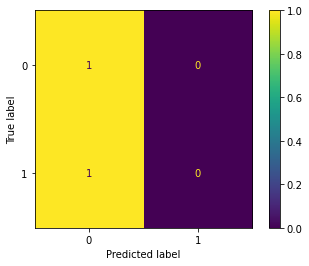

In [22]:
lr_clf = LogisticRegression(random_state=0, max_iter=100, penalty = 'l2', solver='liblinear',C=1, n_jobs=None).fit(x_train, y_train)
plot_confusion_matrix(estimator = lr_clf, X=x_test, y_true = y_test,normalize='true')